In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW 

In [3]:
train_essays_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_essays\\train_essays.csv")
train_prompts_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_prompts.csv")
train_drcat1_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_drcat_01\\train_drcat_01.csv")
train_drcat2_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_drcat_02\\train_drcat_02.csv")
train_drcat3_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_drcat_03\\train_drcat_03.csv")
train_drcat4_df = pd.read_csv("C:\\Users\\parim\\Downloads\\train_drcat_04\\train_drcat_04.csv")
print(f" Training dataset shape: {train_essays_df.shape}, Training dataset columns: {train_essays_df.columns}")
print(f" Training prompts shape: {train_prompts_df.shape} Training prompts columns: {train_prompts_df.columns}")
print(f" Train drcat1 dataset shape: {train_drcat1_df.shape}, Training drcat1 dataset columns: {train_drcat1_df.columns}")
print(f" Training drcat2 dataset shape: {train_drcat2_df.shape}, Training drcat2 dataset columns: {train_drcat2_df.columns}")
print(f" Training drcat3 dataset shape: {train_drcat3_df.shape}, Training drcat3 dataset columns: {train_drcat3_df.columns}")
print(f" Training drcat4 dataset shape: {train_drcat4_df.shape}, Training drcat4 dataset columns: {train_drcat4_df.columns}")


 Training dataset shape: (1378, 4), Training dataset columns: Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')
 Training prompts shape: (2, 4) Training prompts columns: Index(['prompt_id', 'prompt_name', 'instructions', 'source_text'], dtype='object')
 Train drcat1 dataset shape: (33259, 4), Training drcat1 dataset columns: Index(['text', 'label', 'source', 'fold'], dtype='object')
 Training drcat2 dataset shape: (39785, 6), Training drcat2 dataset columns: Index(['essay_id', 'text', 'label', 'source', 'prompt', 'fold'], dtype='object')
 Training drcat3 dataset shape: (42206, 6), Training drcat3 dataset columns: Index(['essay_id', 'text', 'label', 'source', 'prompt', 'fold'], dtype='object')
 Training drcat4 dataset shape: (44206, 6), Training drcat4 dataset columns: Index(['essay_id', 'text', 'label', 'source', 'prompt', 'fold'], dtype='object')


In [4]:
train_essays_df.head(3)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0


In [5]:
train_prompts_df.head(5)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [6]:
train_drcat1_df.head(2)

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4


In [7]:
train_drcat2_df.head(2)

,essay_id,text,label,source,prompt,fold
0,E0B86027C5C5,"Okay, here is my essay:\n\nWorking or doing th...",1,llama2_chat,Task: \n\n1. Research the benefits of working ...,1
1,8B9EEF86DD66,"Dear Principal,\r\n\r\nI just want to let you ...",0,original_moth,Task: Research the effects of implementing a p...,2


In [8]:
train_drcat3_df.head(2)

,essay_id,text,label,source,prompt,fold
0,6BB4BEB51A80,People can learn without making mistakes. Peop...,0,original_moth,Task: \n\nWrite an essay examining the ways in...,1
1,30A8FB981469,PHONES AND DRIVING\n\nIn this world in which w...,0,persuade_corpus,NaN,2


In [9]:
train_drcat4_df.head(2)

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2


In [10]:
train_drcat_df = pd.concat([train_drcat1_df, train_drcat2_df, train_drcat3_df, train_drcat4_df], ignore_index=True)
train_drcat_df.shape, train_drcat_df.columns

((159456, 6),
 Index(['text', 'label', 'source', 'fold', 'essay_id', 'prompt'], dtype='object'))

In [11]:
train_drcat_df['label'].value_counts()

label
0    115372
1     44084
Name: count, dtype: int64

In [12]:
train_essays_df['generated'].unique(), train_essays_df['prompt_id'].unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [13]:
train_essays_df.columns

Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')

In [14]:
train_essays_df =  train_essays_df.drop(columns=["id", "prompt_id"])
train_essays_df.rename(columns={'generated': 'label'}, inplace=True)
train_essays_df.shape, train_essays_df.columns

((1378, 2), Index(['text', 'label'], dtype='object'))

Exploratory Data Analysis

In [15]:
#train_drcat_df.groupby(['source']).sum()
train_df = pd.concat([train_drcat1_df, train_drcat2_df, train_drcat3_df, train_drcat4_df], axis=0)
train_df.shape, train_df.columns

((159456, 6),
 Index(['text', 'label', 'source', 'fold', 'essay_id', 'prompt'], dtype='object'))

In [16]:
#sns.countplot(train_drcat_df, x='label', hue='label')
train_df = train_df.drop(columns=['source', 'fold', 'essay_id', 'prompt'])
train_df.shape, train_df.columns

((159456, 2), Index(['text', 'label'], dtype='object'))

In [17]:
train1_df = pd.concat([train_essays_df, train_df], axis=0)
train1_df.shape, train1_df.columns

((160834, 2), Index(['text', 'label'], dtype='object'))

In [18]:
train1_df['label'].value_counts()

label
0    116747
1     44087
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

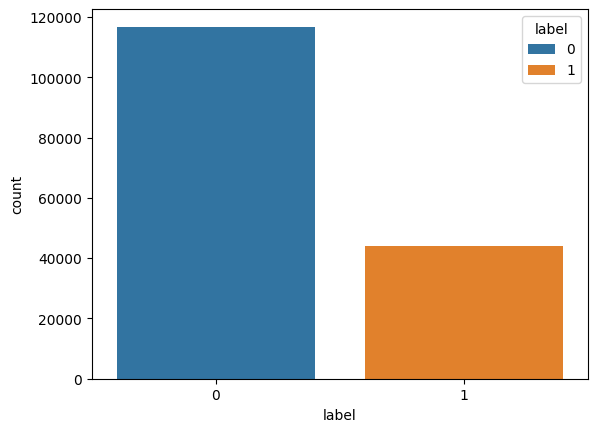

In [19]:
sns.countplot(train1_df, x='label', hue='label')

In [20]:
selected_records = train1_df[train1_df['label']==0].sample(n=48000, random_state=42)
train_final_df = pd.concat([selected_records, train1_df[train1_df['label']==1]], axis=0)
train_final_df['label'].value_counts()

label
0    48000
1    44087
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

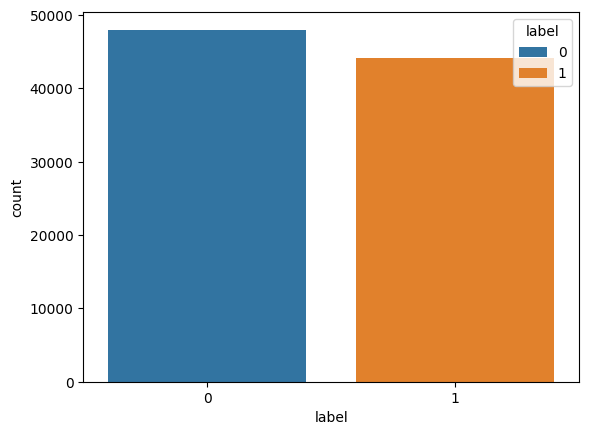

In [21]:
sns.countplot(train_final_df, x='label', hue='label')

Preprocessing

In [22]:
!pip install nltk

In [23]:

#nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    tokens = nltk.word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:

preprocessed_txt = [preprocess_text(sentence) for sentence in train_final_df['text']]


In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_txt)
print(f"tfidf matrix: {tfidf_matrix}")

tfidf matrix:   (0, 36279)	0.023390914969794736
  (0, 45541)	0.011013953302354154
  (0, 43915)	0.012324169492813359
  (0, 44678)	0.026333107212586266
  (0, 21974)	0.017388502622687246
  (0, 47453)	0.02397904482515207
  (0, 9297)	0.014003098179790055
  (0, 8751)	0.01669148810279092
  (0, 37794)	0.023793960874931682
  (0, 34828)	0.026964805347051472
  (0, 49845)	0.0277141325510311
  (0, 43447)	0.022065970166574297
  (0, 27083)	0.010623848085576842
  (0, 33689)	0.043189806719457886
  (0, 23193)	0.02330060015354612
  (0, 20038)	0.013999635527985997
  (0, 33435)	0.01968118439057786
  (0, 49377)	0.01614796057894708
  (0, 3096)	0.025442516087329555
  (0, 3295)	0.04590481464068514
  (0, 15667)	0.022392829098973006
  (0, 36897)	0.06809622635587573
  (0, 4280)	0.052615454766462774
  (0, 21322)	0.01123912617405223
  (0, 16504)	0.025284227573025984
  :	:
  (92086, 18395)	0.02837095959176277
  (92086, 23533)	0.035106918342138776
  (92086, 29364)	0.13112312668173487
  (92086, 50140)	0.02130456444021

In [26]:
X = tfidf_matrix
y = train_final_df['label']

In [27]:
# log_regression = LogisticRegression()
# multinomial_nb = MultinomialNB()
# rand_forest = RandomForestClassifier()
# svm_classifier = SVC()

# log_regression.fit(X, y)
# multinomial_nb.fit(X, y)
# rand_forest.fit(X, y)
# svm_classifier.fit(X, y)

# train_log_reg_pred = log_regression.predict(X)
# train_multinomial_pred = multinomial_nb.predict(X)
# train_rand_for_pred = rand_forest.predict(X)
# train_svm_pred = svm_classifier.predict(X)

# print(f"Logistic Regression train acc: {accuracy_score(y, train_log_reg_pred)} \n \
#       Multinomial NB train acc: {accuracy_score(y, train_multinomial_pred)} \n \
#       Random Forest train acc: {accuracy_score(y, train_rand_for_pred)} \n \
#         SVM classifier's train acc: {accuracy_score(y, train_svm_pred)}")

In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

C:\Users\parim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
test_df = pd.read_csv("C:\\Users\\parim\\Downloads\\test_essays.csv")
test_df.shape, test_df.columns

((3, 3), Index(['id', 'prompt_id', 'text'], dtype='object'))

In [30]:
X_test = test_df["text"]

In [31]:
# train_log_reg_pred = log_regression.predict(X)
# train_multinomial_pred = multinomial_nb.predict(X)
# train_rand_for_pred = rand_forest.predict(X)
# train_svm_pred = svm_classifier.predict(X)

# print(f"Logistic Regression train acc: {accuracy_score(y, train_log_reg_pred)} \n \
#       Multinomial NB train acc: {accuracy_score(y, train_multinomial_pred)} \n \
#       Random Forest train acc: {accuracy_score(y, train_rand_for_pred)} \n \
#         SVM classifier's train acc: {accuracy_score(y, train_svm_pred)}")

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 30.8kB/s]
C:\Users\parim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\parim\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  wa

In [35]:
X_train = X.astype(str).tolist()
train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(y.tolist())

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).